In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# TensorFlow and Keras Libraries
from tensorflow.keras import layers, models, Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    RandomFlip, RandomRotation, RandomZoom,
    Dense, Dropout, Input
)

# System Libraries
from pathlib import Path
import os
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


In [3]:
# Walk through each directory
dataset = "D:\Jupyter Lab\garbage_classification\garbage_classification"
walk_through_dir(dataset);

There are 12 directories and 0 images in 'D:\Jupyter Lab\garbage_classification\garbage_classification'.
There are 0 directories and 945 images in 'D:\Jupyter Lab\garbage_classification\garbage_classification\battery'.
There are 0 directories and 985 images in 'D:\Jupyter Lab\garbage_classification\garbage_classification\biological'.
There are 0 directories and 607 images in 'D:\Jupyter Lab\garbage_classification\garbage_classification\brown-glass'.
There are 0 directories and 891 images in 'D:\Jupyter Lab\garbage_classification\garbage_classification\cardboard'.
There are 0 directories and 5325 images in 'D:\Jupyter Lab\garbage_classification\garbage_classification\clothes'.
There are 0 directories and 629 images in 'D:\Jupyter Lab\garbage_classification\garbage_classification\green-glass'.
There are 0 directories and 824 images in 'D:\Jupyter Lab\garbage_classification\garbage_classification\metal'.
There are 0 directories and 1050 images in 'D:\Jupyter Lab\garbage_classification\gar

In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

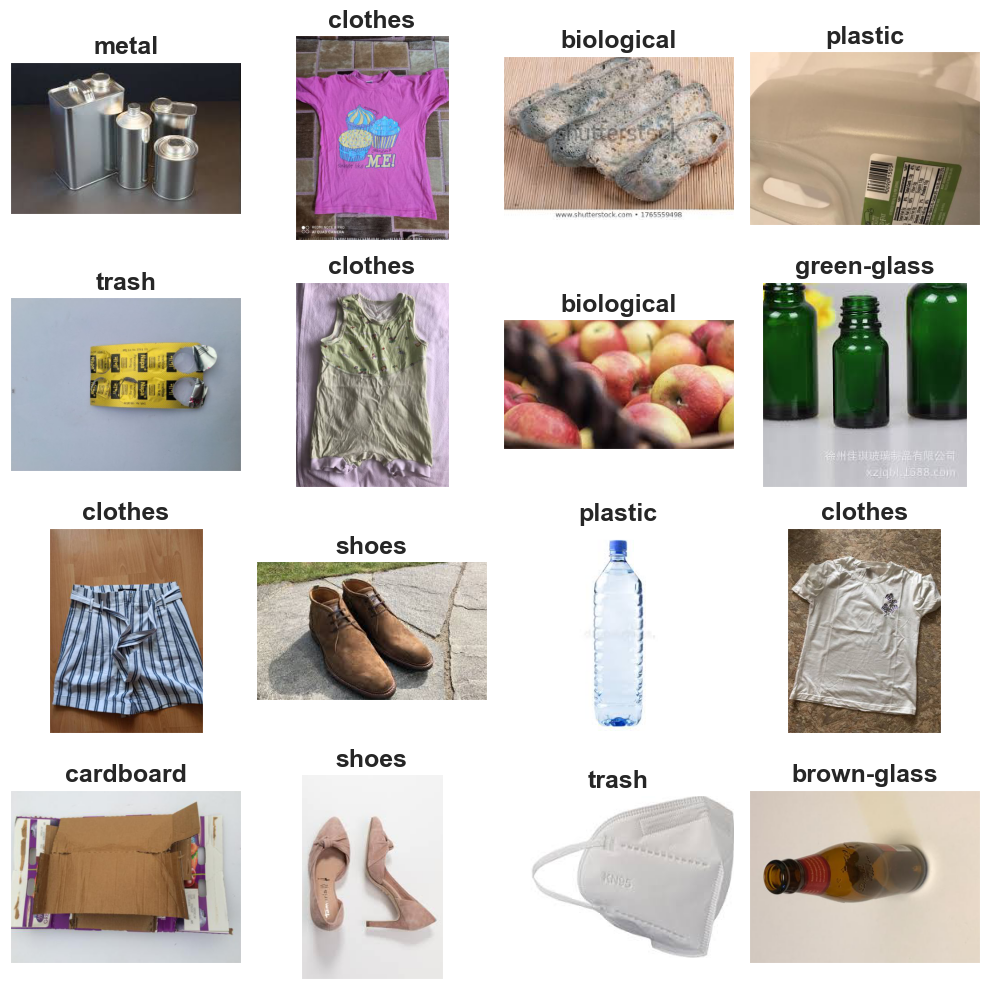

In [6]:
# Display 8 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]],
                fontsize=18,
                fontweight='bold' )
plt.tight_layout()
plt.show()

C:\Users\Mehedi-482\AppData\Local\Temp\ipykernel_18216\1612252195.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


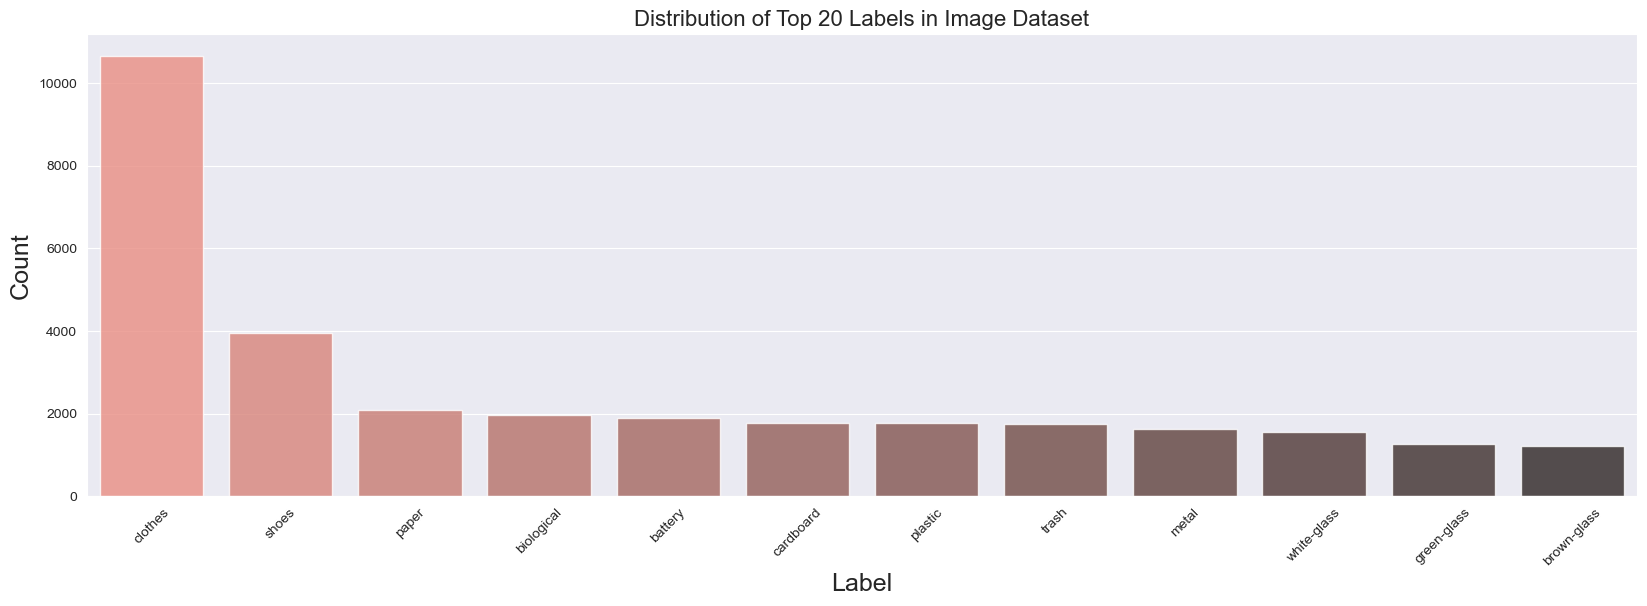

In [7]:
# Get the top 20 labels
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [8]:
augment = Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])


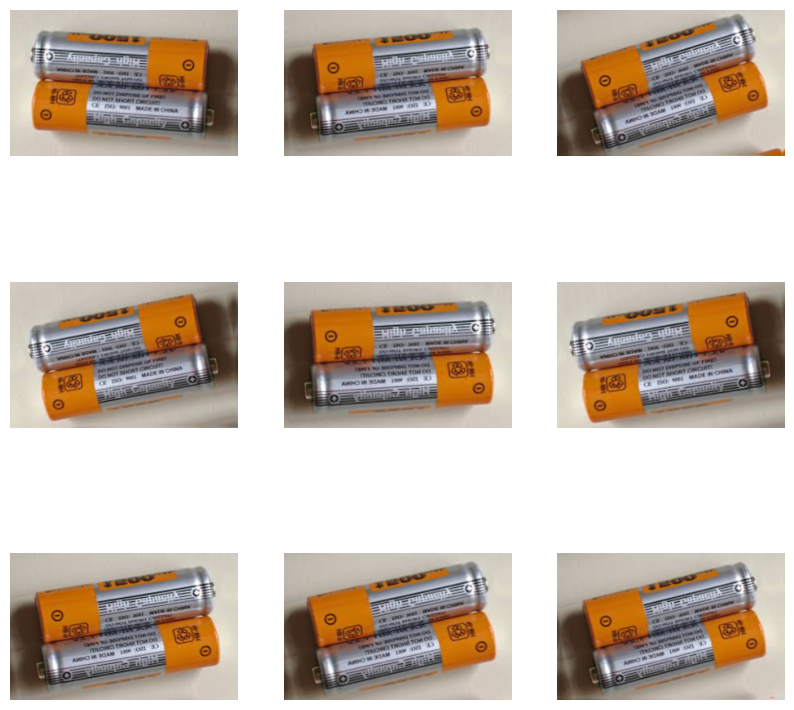

In [9]:
import matplotlib.pyplot as plt

sample = plt.imread(image_df.Filepath[0])
sample = tf.expand_dims(sample, 0)  # add batch dim

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented = augment(sample)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented[0].numpy())
    plt.axis("off")
plt.show()


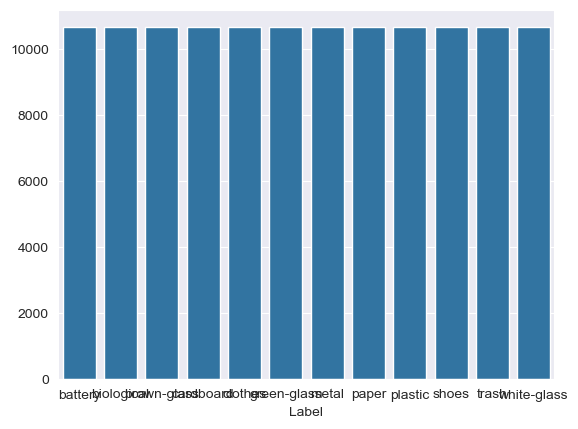

In [10]:
from sklearn.utils import resample

# Separate majority and minority classes
max_count = image_df['Label'].value_counts().max()
balanced_dfs = []

for label, group in image_df.groupby('Label'):
    balanced_group = resample(group,
                              replace=True,     # resample with replacement
                              n_samples=max_count, # match majority class
                              random_state=42)
    balanced_dfs.append(balanced_group)

balanced_df = pd.concat(balanced_dfs)

# Now plot new distribution
label_counts = balanced_df['Label'].value_counts()[:20]
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.show()


In [11]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [12]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [13]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 20161 validated image filenames belonging to 12 classes.
Found 5040 validated image filenames belonging to 12 classes.
Found 6301 validated image filenames belonging to 12 classes.


In [14]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

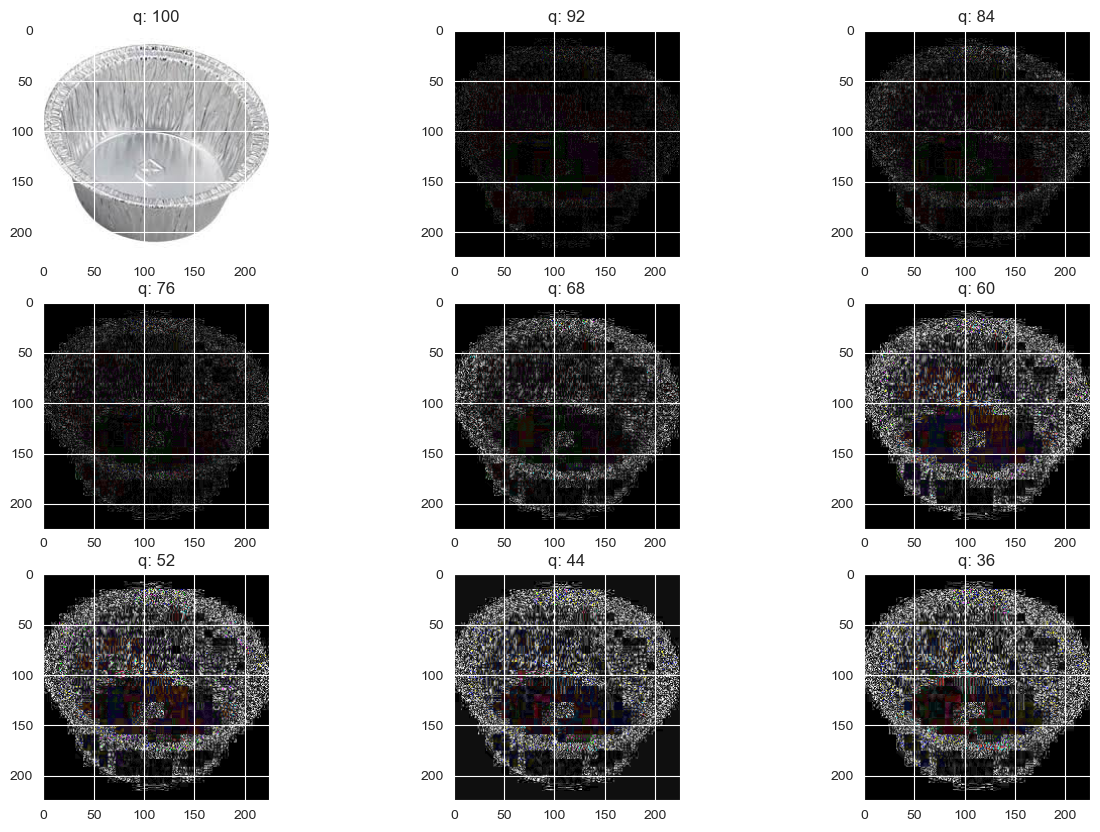

In [15]:
# View random sample from the dataset
p = random_sample('D:\Jupyter Lab\garbage_classification\garbage_classification\metal')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [16]:

# # Define augmentation
# augment = Sequential([
#     layers.Rescaling(1./255),
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
# ])

In [17]:
# Load the pretained model EfficientNetB0
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

# Create checkpoint callback
checkpoint_path = "Garbage_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(12, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history1 = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "Garbage_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/Garbage_classification/20251031-162846
Epoch 1/10
631/631 [==============================] - 132s 198ms/step - loss: 1.1208 - accuracy: 0.6783 - val_loss: 0.3966 - val_accuracy: 0.8847 - lr: 1.0000e-04
Epoch 2/10
631/631 [==============================] - 61s 96ms/step - loss: 0.4641 - accuracy: 0.8586 - val_loss: 0.2647 - val_accuracy: 0.9216 - lr: 1.0000e-04
Epoch 3/10
631/631 [==============================] - 61s 97ms/step - loss: 0.3404 - accuracy: 0.8947 - val_loss: 0.2213 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 4/10
631/631 [==============================] - 61s 97ms/step - loss: 0.2746 - accuracy: 0.9131 - val_loss: 0.1853 - val_accuracy: 0.9460 - lr: 1.0000e-04
Epoch 5/10
631/631 [==============================] - 61s 97ms/step - loss: 0.2266 - accuracy: 0.9275 - val_loss: 0.1587 - val_accuracy: 0.9522 - lr: 1.0000e-04
Epoch 6/10
631/631 [==============================] - 61s 97ms/step - loss: 0.1935 - accuracy: 0.9389 - val

197/197 [==============================] - 16s 79ms/step


C:\Users\Mehedi-482\AppData\Local\Temp\ipykernel_18216\1835267105.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


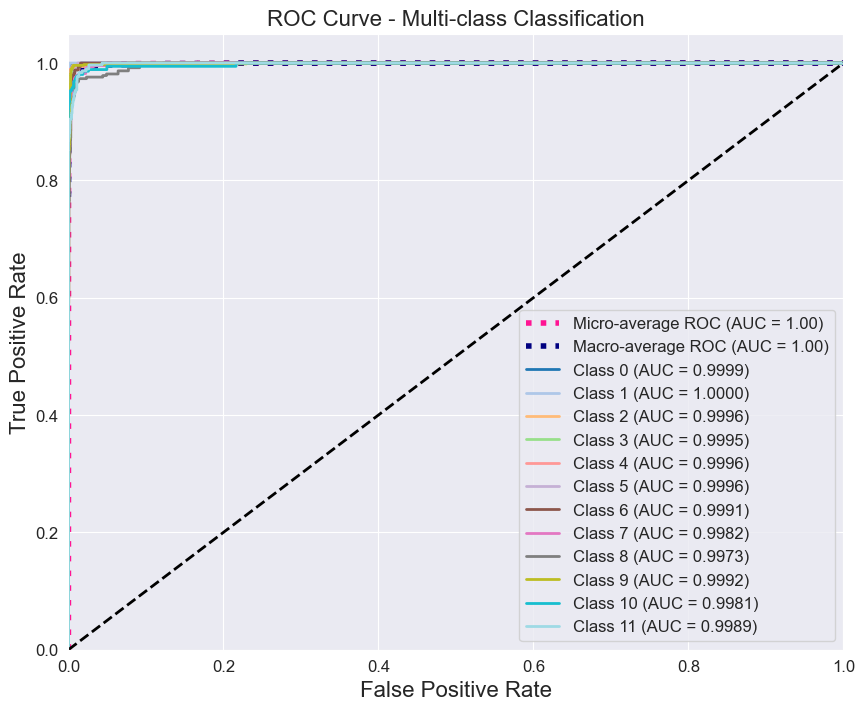

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf  # make sure TensorFlow is imported

# Reset generator so predictions start from beginning
test_images.reset()

# Predict probabilities
y_score = model.predict(test_images, steps=len(test_images), verbose=1)

# True labels (convert to one-hot)
num_classes = len(test_images.class_indices)
y_true = tf.keras.utils.to_categorical(test_images.classes, num_classes=num_classes)

# Binarize labels (redundant if already one-hot, but safe)
y_true = label_binarize(test_images.classes, classes=list(range(num_classes)))

# Store per-class ROC
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC
# First aggregate all FPR points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(10, 8))

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = plt.cm.get_cmap('tab20', num_classes)
for i, color in zip(range(num_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], lw=2, color=color,
             label=f"Class {i} (AUC = {roc_auc[i]:.4f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve - Multi-class Classification", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


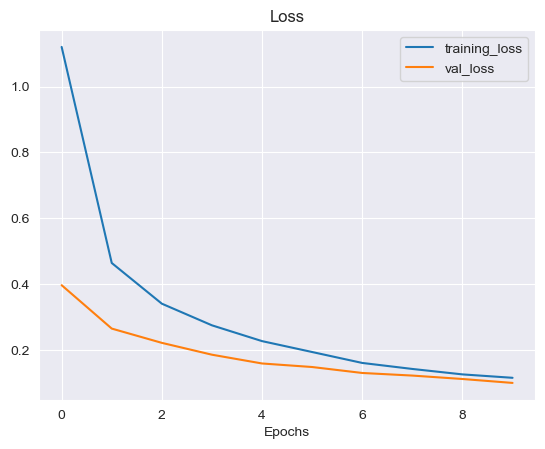

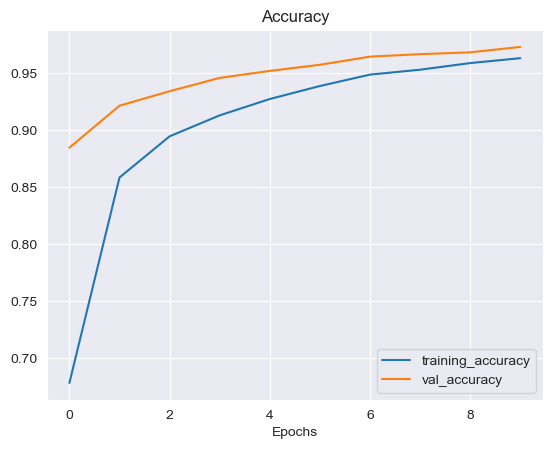

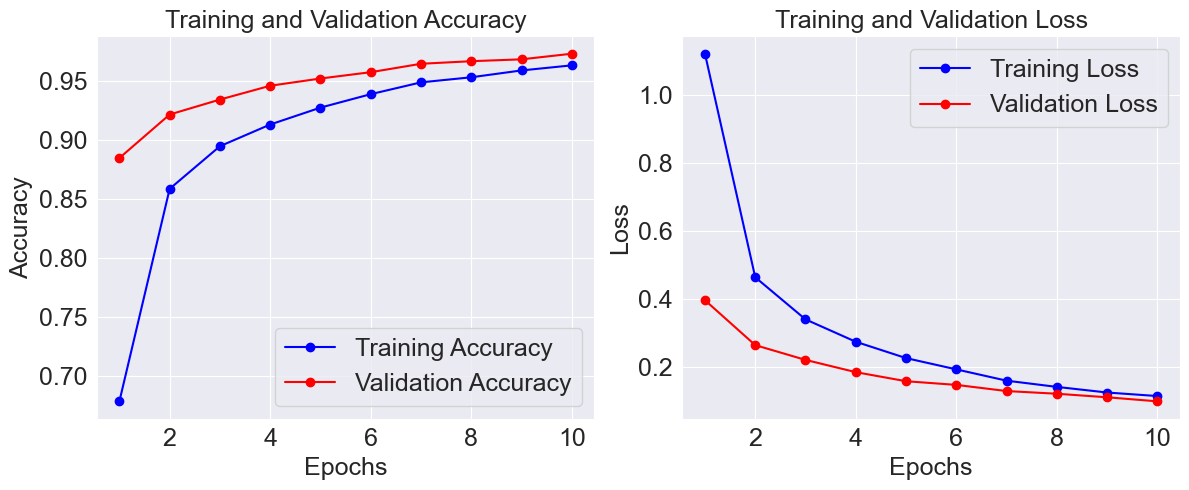

In [20]:
import matplotlib.pyplot as plt

# Epochs
epochs = range(1, len(history1.history['accuracy']) + 1)

# Training & validation accuracy
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

# Training & validation loss
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Optional: Plot training and validation curves using helper function (if available)
plot_loss_curves(history1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()
